# Download DAHITI
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 13-02-2025*<br>

**Description**<br>

This code downloads data from the [DAHITI](https://dahiti.dgfi.tum.de/en/) dataset using its API version 2. 

It requires two inputs:
1. A TXT file (_api_key.txt_) with the API key associated to your DAHITI user.
2. A YAML file with the DAHITI ID of the points of interes.

It searches for available time series of water level, surface area and volume variation.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import requests
import json
import yaml
from tqdm.auto import tqdm
import geopandas as gpd
from shapely import Point
import pprint
from pathlib import Path

## Configuration

In [35]:
PATH_DAHITI = Path('Z:/nahaUsers/casadje/datasets/DAHITI')

API_URL = 'https://dahiti.dgfi.tum.de/api/v2/'

# personal API key
with open('api_key.txt', 'r') as txt:
    api_key = txt.readline().strip()

# selection of targets
with open('arguments.yml', 'r') as file:
    args = yaml.safe_load(file)
args['api_key'] = api_key

print(args)

TYPE = 'reservoir'
COUNTRY = ['Brazil', 'Paraguay', 'Argentina']

{'api_key': '2676835AF649F11F825EB24729EEACFDC945263C0F12F2561CF24D315F8F10D1'}


In [23]:
MAP_VAR_NAMES = {
    'target_name': 'name',
    'water_level_altimetry': 'level',
    'surface_area': 'area',
    'water_occurrence_mask': 'occurrence',
    'land_water_mask': 'land_water',
    'volume_variation': 'volume',
    'water_level_hypsometry': 'level_hyps'
}

## Data
### Targets

In [28]:
# requests targets
response = requests.post(
    url=f'{API_URL}/list-targets/',
    json=args
)

if response.status_code == 200:
    targets = json.loads(response.text)
else:
    error = json.loads(response.text)
    print('Error {0}:\t{1}'.format(error['code'], error['message']))

# # export list of targets
# with open(PATH_DAHITI / 'list-targets.json', 'w') as f:
#     json.dump(targets['data'], f, indent=4)
print('DAHITI contains {0} targets.'.format(len(targets['data'])))

# filter targets by type
targets = [target for target in targets['data'] if target['type'].lower() == TYPE]
print('DAHITI contains {0} targets of type {1}.'.format(len(targets), TYPE))

# convert to DataFrame
target_list = []
variables = []
for reservoir in targets:
    serie = pd.concat((
        pd.Series({key: value for key, value in reservoir.items() if key != 'data_access'}),
        pd.Series(reservoir['data_access'])
    ), axis=0)
    variables += list(reservoir['data_access'])
    target_list.append(serie)
targets = pd.concat(target_list, axis=1).T
targets.dahiti_id = targets.dahiti_id.astype(int)
targets[['longitude', 'latitude']] = targets[['longitude', 'latitude']].astype(float)
variables = list(set(variables))
targets[variables] = targets[variables].astype(bool)
targets.set_index('dahiti_id', drop=True, inplace=True)

# convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(targets.longitude, targets.latitude)]
targets = gpd.GeoDataFrame(targets, geometry=geometry)
targets = targets.set_crs(epsg=4326)

# shorten variable names
targets.rename(columns=MAP_VAR_NAMES, inplace=True)

# export shapefile of targets
PATH_OUT = PATH_DAHITI / TYPE / 'targets'
PATH_OUT.mkdir(parents=True, exist_ok=True)
output_file = PATH_OUT / f'DAHITI_{TYPE}.shp'
targets.to_file(output_file, driver='ESRI Shapefile')
print(f'Shapefile of targets saved in:\t{output_file}')

In [131]:
# targets.to_fi(PATH_DAHITI / 'targets_BrArPy.csv')

In [49]:
targets[MAP_VAR_NAMES.values()].sum()

name          Abiquiu, ReservoirAcude Coremas, ReservoirAcud...
level                                                       485
area                                                        100
occurrence                                                   98
land_water                                                   98
volume                                                       38
level_hyps                                                   38
dtype: object

### Timeseries

In [44]:
# filter targets by country
mask_country = targets.country.isin(COUNTRY)
targets_country = targets[mask_country]
print('DAHITI contains {0} targets in {1}.'.format(len(targets_country), ', '.join(COUNTRY)))

DAHITI contains 70 targets in Brazil, Paraguay, Argentina.


In [45]:
variables

['bathymetry',
 'water_level_hypsometry',
 'hypsometry',
 'land_water_mask',
 'volume_variation',
 'surface_area',
 'discharge',
 'water_occurrence_mask',
 'water_level_altimetry']

In [42]:
variables = [var.replace('_', '-') for var in variables]

In [180]:
targets_parana = gpd.read_file(PATH_DAHITI / TYPE / 'targets' / 'DAHITI_reservoir_parana.shp').set_index('dahiti_id', drop=True)
targets_parana.index = targets_parana.index.astype(int)
targets_parana.GRAND_ID = targets_parana.GRAND_ID.astype('Int64')
map_columns = {new: old.replace('_', '-') for old, new in MAP_VAR_NAMES.items() if 'name' not in old}
targets_parana.rename(columns=map_columns, inplace=True)
cols = list(map_columns.values())
targets_parana[cols] = targets_parana[cols].astype(int)
targets_parana.rename(columns={'water-level-altimetry': 'water-level'}, inplace=True)

In [181]:
targets_parana.columns

Index(['name', 'location', 'continent', 'country', 'longitude', 'latitude',
       'type', 'water-level', 'surface-area', 'water-occurrence-mask',
       'land-water-mask', 'volume-variation', 'hypsometry', 'bathymetry',
       'water-level-hypsometry', 'discharge', 'GRAND_ID', 'geometry'],
      dtype='object')

In [182]:
VARS = [
    'water-level',
    'surface-area',
    'volume-variation',
    'hypsometry'
]

timeseries = {}
for ID in tqdm(targets_parana.index):
    ts_id = pd.DataFrame(dtype=float)
    
    for var in VARS:
        if targets_parana.loc[ID, var] == 0:
            continue

        # request info to the API
        response = requests.post(
            f'{API_URL}download-{var}/',
            json={
                'api_key': api_key,
                'format': 'json',
                'dahiti_id': ID,
            }
        )

        if response.status_code == 200:
            # load as dictionary
            data = json.loads(response.text)

            # extract timeseries
            try:
                df = pd.DataFrame.from_dict(data['data'])
                index_col = [col for col in df.columns if col.startswith('date')][0]
                df.set_index(index_col, drop=True, inplace=True)
                df.index = pd.to_datetime(df.index).date
                df.rename(columns={'error': f'{var}_error'}, inplace=True)
                df.index.name = 'date'
                # concatenate to the timeseries of other variables
                ts_id = pd.concat((ts_id, df), axis=1)
                del df
            except Exception as e:
                print(f'Time series from ID {ID} could not be retrieved:\n{e}', flush=True)
            
            del data
        else:
            error = json.loads(response.text)
            print('Error while downloading {0} for target {1}:\n{2}:\t{3}'.format(var, ID, error['code'], error['message']))
            continue
            
    if len(ts_id) > 0:
        ts_id.sort_index(inplace=True)
        timeseries[ID] = ts_id

  0%|          | 0/25 [00:00<?, ?it/s]

Time series from ID 10434 could not be retrieved:
list index out of range
Time series from ID 10345 could not be retrieved:
If using all scalar values, you must pass an index
Time series from ID 10351 could not be retrieved:
If using all scalar values, you must pass an index


In [183]:
# export timeseries
PATH_OUT = PATH_DAHITI / TYPE / 'time_series'
PATH_OUT.mkdir(parents=True, exist_ok=True)
for ID, ts in timeseries.items():
    ts.to_csv(PATH_OUT / f'{ID}.csv')

In [77]:
import matplotlib.pyplot as plt

C:\Users\casadje\AppData\Local\Temp\ipykernel_14968\1585751098.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


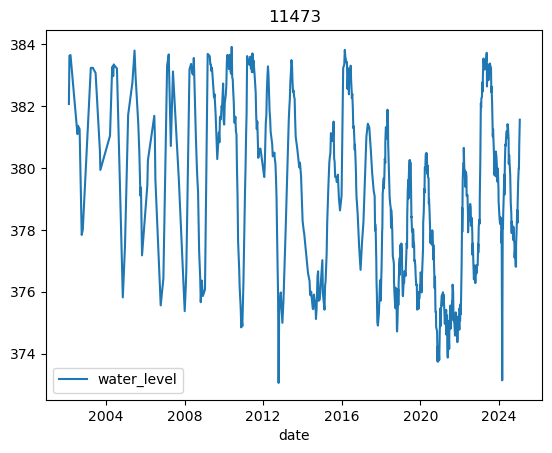

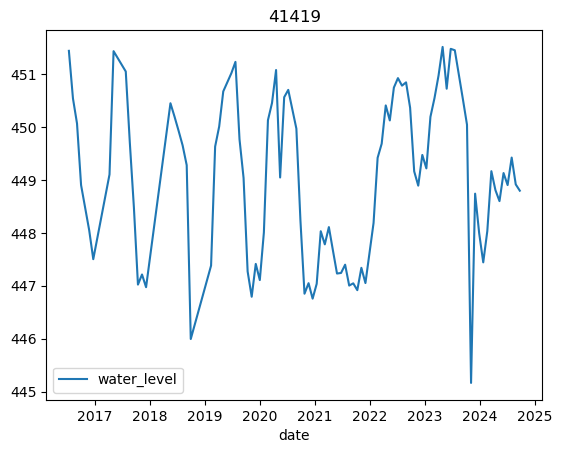

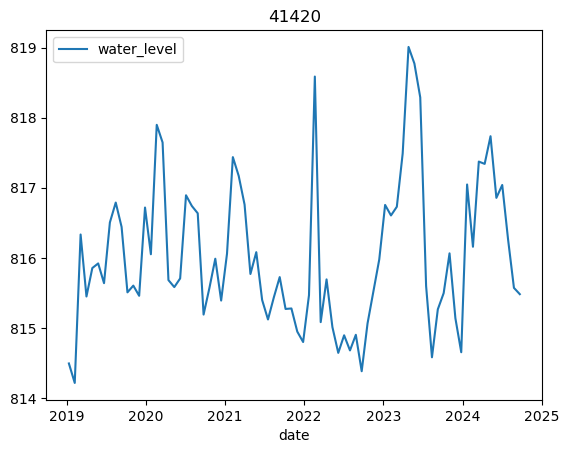

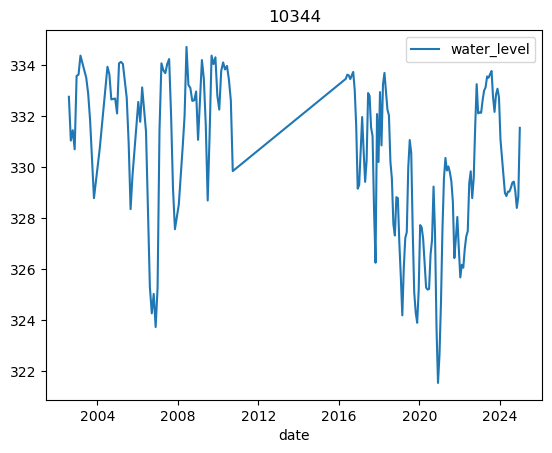

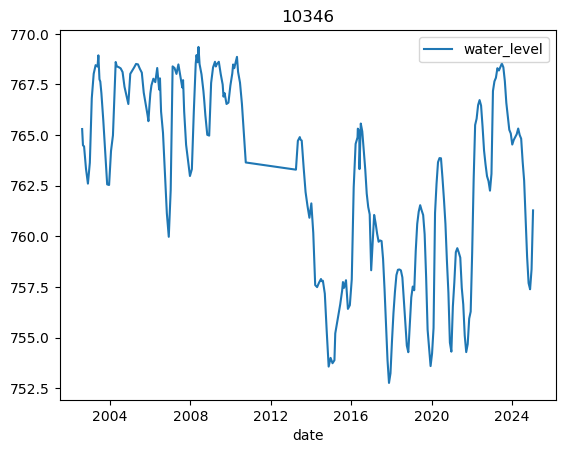

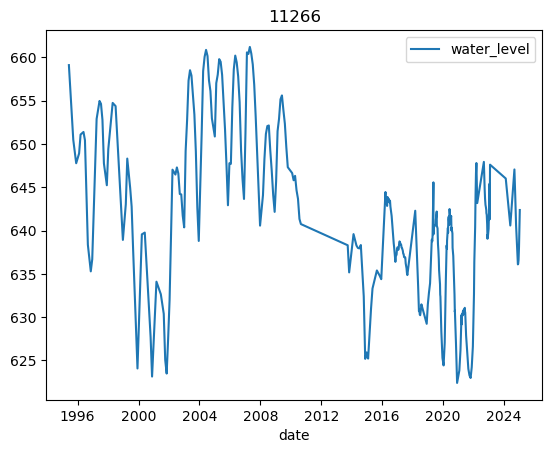

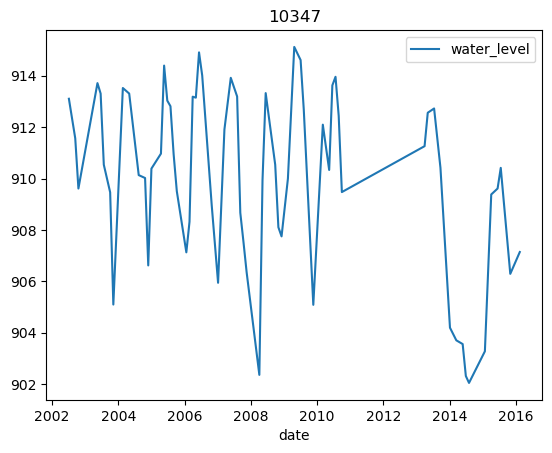

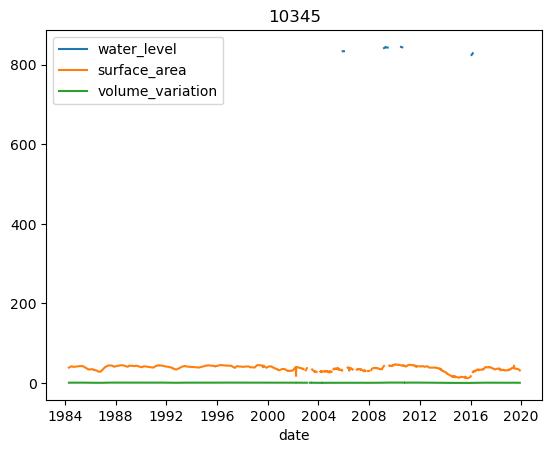

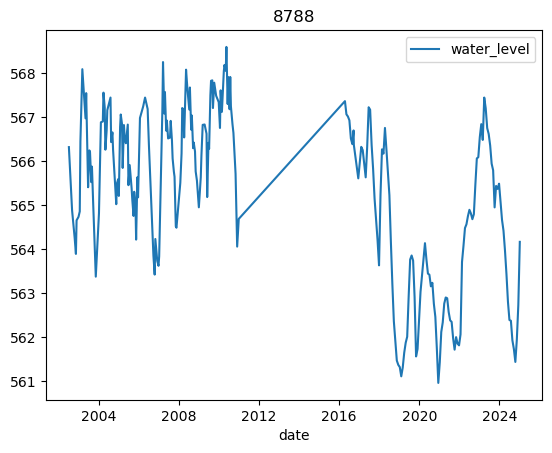

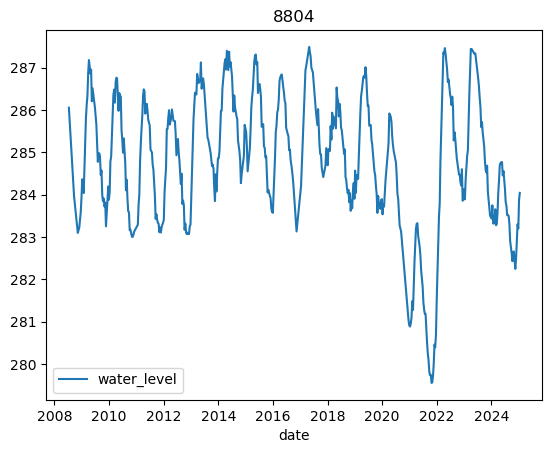

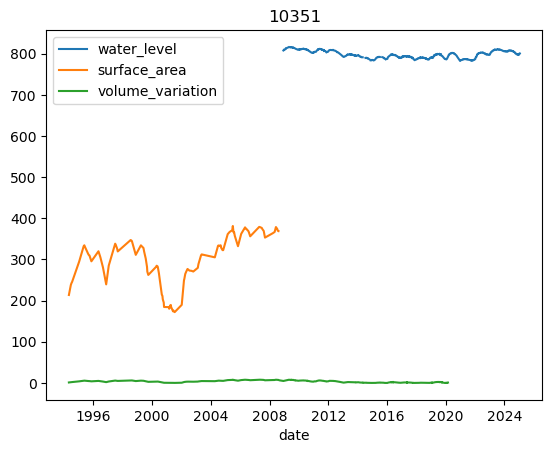

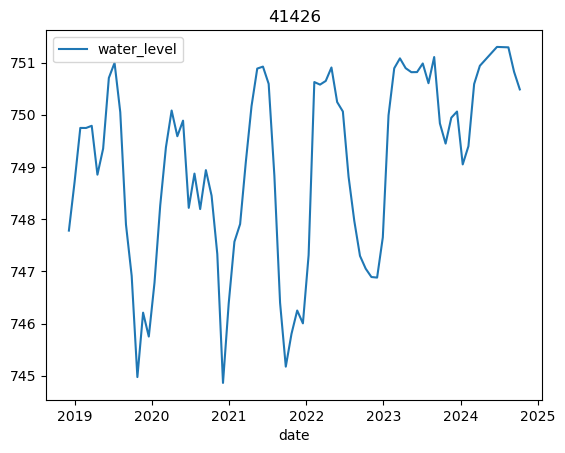

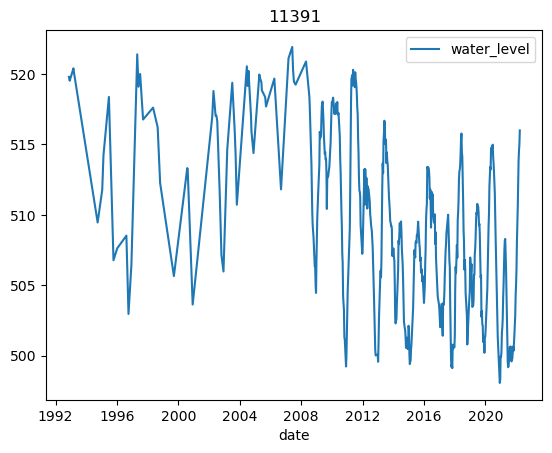

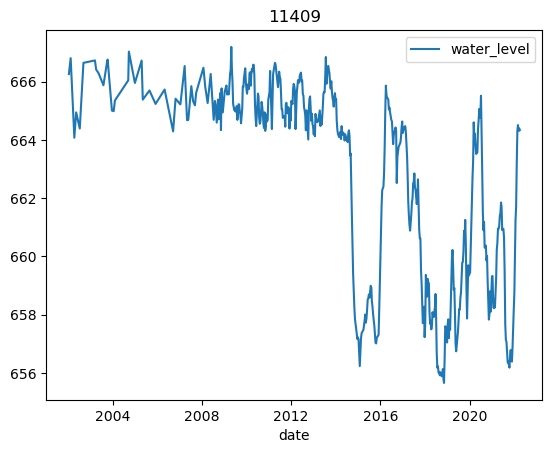

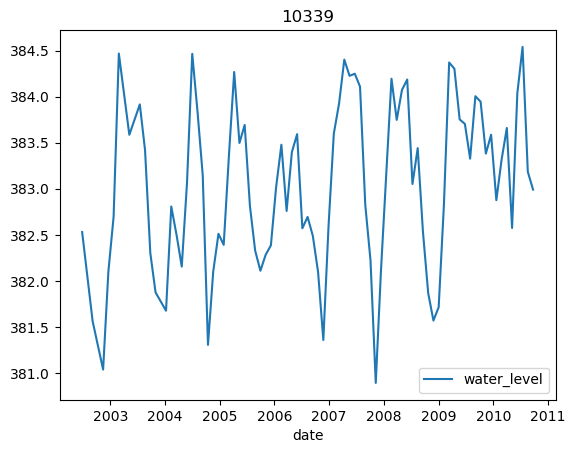

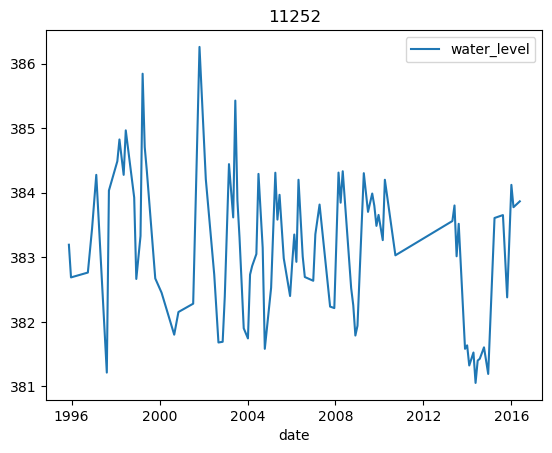

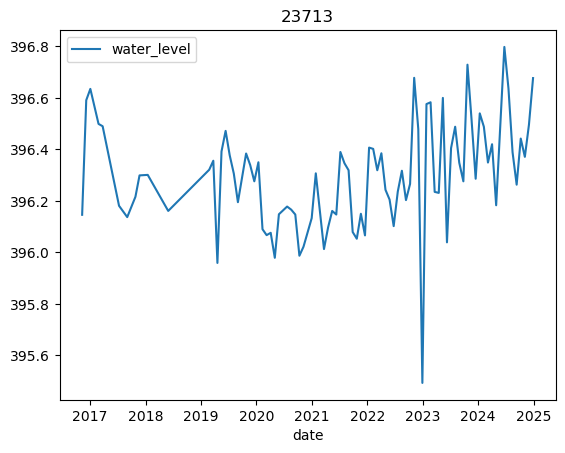

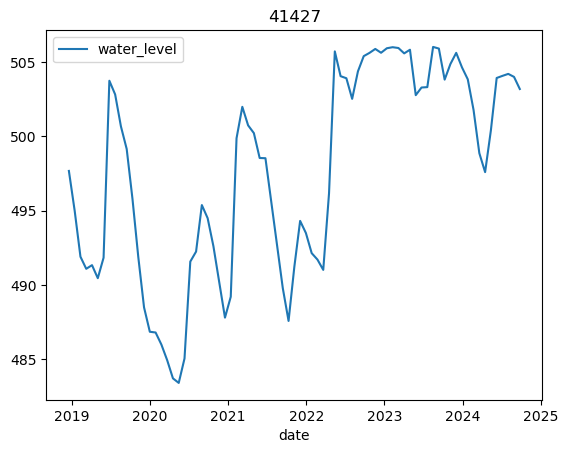

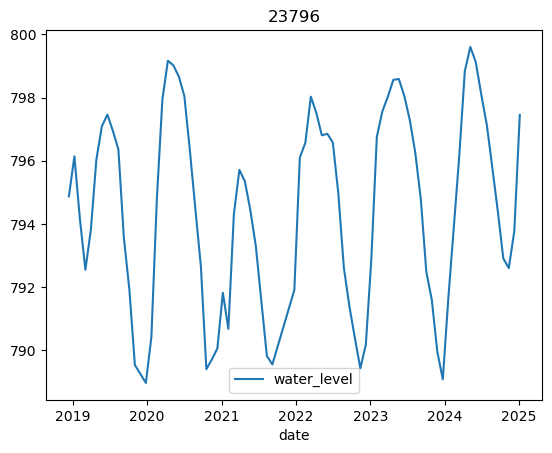

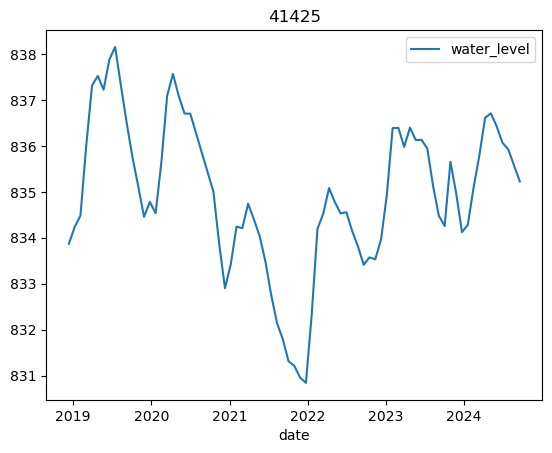

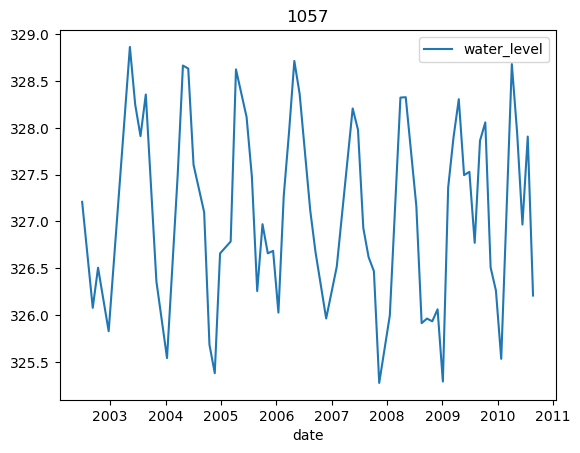

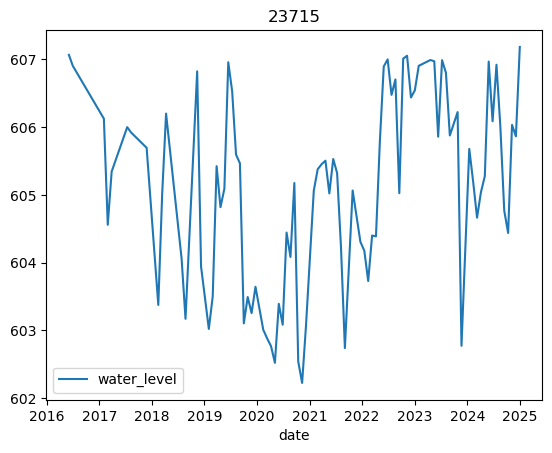

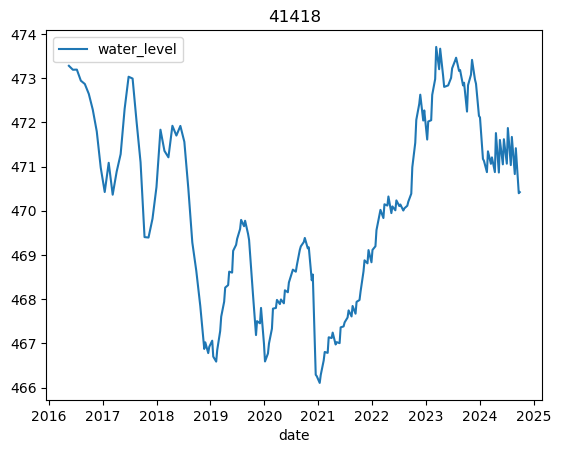

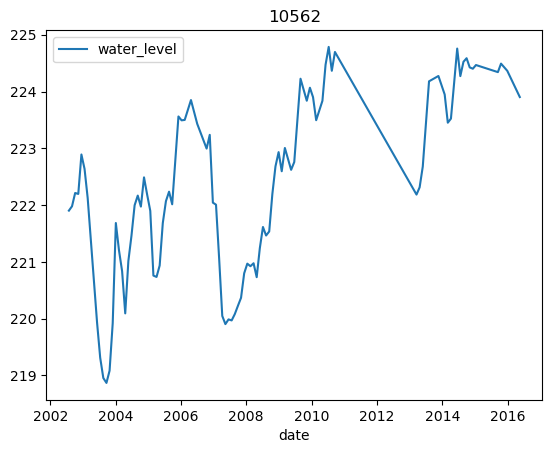

In [184]:
for ID, ts in timeseries.items():
    fig, ax = plt.subplots()
    ts[[col for col in ts.columns if 'error' not in col]].plot(ax=ax)
    ax.set_title(ID)

## Export